In [1]:
import os
import torch
import numpy as np

from dataset import PatchDataset
from model import PatchClassifier, ModelHandler
import config

from PIL import Image
import matplotlib.pyplot as plt

import lovely_tensors as lt

In [2]:
layer_idx = 4
INF_DICE = 88.24

mh = ModelHandler(
    PatchClassifier(
        features_only=config.FEATURES_ONLY, 
        out_classes=config.NUM_CLASSES,
        freeze_encoder=config.FREEZE_ENCODER)
)
mh.load(os.path.join(config.MODEL_FOLDER, f'{config.CONFIG_ID}_{INF_DICE}.pt'))
model = mh.model.model
model.requires_grad_(True)
model.eval()

ref_dataset = PatchDataset(config.DATA_DIR, config.ATF, preproc=False, augment=False)
dataset = PatchDataset(config.DATA_DIR, config.ATF, preproc=True, augment=False)
target_layers = eval(f"[model.layer{layer_idx}[-1]]")

In [3]:
img_idx = np.random.randint(0, len(ref_dataset))
classes = list(dataset.class_to_idx.keys())
class_imgs = {}

# np.random.seed(42)
for class_name in classes:
    class_idx = ref_dataset.class_to_idx[class_name]
    class_img_idx = np.random.choice(np.where(np.asarray(dataset.targets) == class_idx)[0])

    img_pil = Image.open(ref_dataset.imgs[class_img_idx])
    img_np_norm = np.asarray(Image.open(dataset.imgs[class_img_idx]).resize(config.INPUT_SIZE)) / 255.0
    input_tensor = dataset[class_img_idx][0].unsqueeze(0).type(torch.FloatTensor)
    probs = mh.get_probs(img_pil, dataset.idx_to_class)

    class_imgs[class_name] = (class_idx, img_pil, img_np_norm, input_tensor, probs)

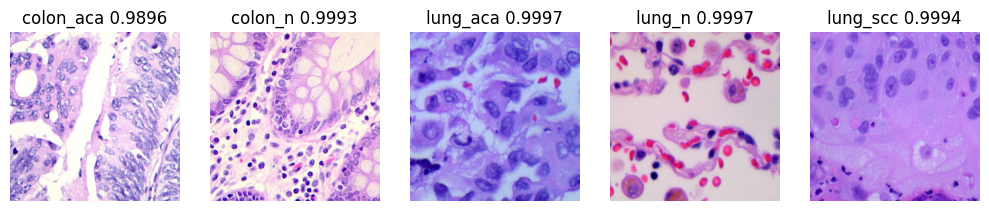

In [4]:
random_class_imgs = [(v[1], k, v[4]) for k, v in class_imgs.items()]
fig, axs = plt.subplots(1, len(random_class_imgs), figsize=(10, 2), constrained_layout=True)
for i, (img, title, probs) in enumerate(random_class_imgs):
    axs[i].imshow(img)
    axs[i].set_title(f"{title} {probs[title]:.4f}")
    axs[i].axis('off')

###########
Guided Backpropagation
###########

In [5]:
class ResNet18(torch.nn.Module):
    def __init__(self, model):
        super(ResNet18, self).__init__()
        self.features = torch.nn.Sequential(*list(model.children())[:-2])
        self.avgpool = torch.nn.Sequential(*list(model.children())[-2:-1])
        self.classifier = torch.nn.Sequential(*list(model.children())[-1:])
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
        
resnet18 = ResNet18(model)

In [6]:
class GuidedBP():
    def __init__(self, model):
        self.model = model
        self.recreated_image = None
        self.activation_maps = []
        self.model.eval()
        self.register_hooks()
        
    def register_hooks(self):
        def first_layer_hook(module, grad_in, grad_out):
            self.recreated_image = grad_in[0]
        
        def forward_hook(module, input_tensor, output_tensor):
            self.activation_maps.append(output_tensor)
        
        def backward_hook(module, grad_in, grad_out):
            grad = self.activation_maps.pop()
            grad[grad > 0] = 1
            
            pos_grad_out = torch.clamp(grad_out[0], min=0.0)
            res_grad_in = pos_grad_out * grad
            
            return (res_grad_in,)
        
        modules = list(self.model.features.named_children())
        
        for name, module in modules:
            if isinstance(module, torch.nn.ReLU):
                module.register_forward_hook(forward_hook)
                module.register_backward_hook(backward_hook)
        
        first_layer = modules[0][1]
        first_layer.register_backward_hook(first_layer_hook)
    
    def visualize(self, input_img, target_class):
        output = self.model(input_img)
        self.model.zero_grad()
        pred = output.argmax().item()
        
        grad_target_map = torch.zeros(output.shape, dtype=torch.float)
        
        if target_class is not None:
            grad_target_map[0][target_class] = 1
        else:
            grad_target_map[0][pred] = 1
        
        output.backward(grad_target_map)
        
        result = self.recreated_image.data[0]
        return result

def clip_and_mask(tensor, mask_threshold=0.8):
    np_img = tensor.permute(1,2,0).numpy()

    norm_img = (np_img - np_img.mean()) / np_img.std()
    norm_img = (norm_img * 0.1) + 0.5

    img = norm_img.clip(0, 1)
    
    if mask_threshold is not None:
        mask = np.all(img < mask_threshold, axis=2)
        img[mask] = 0

    img = np.array(img * 255, dtype=np.uint8)
    return img

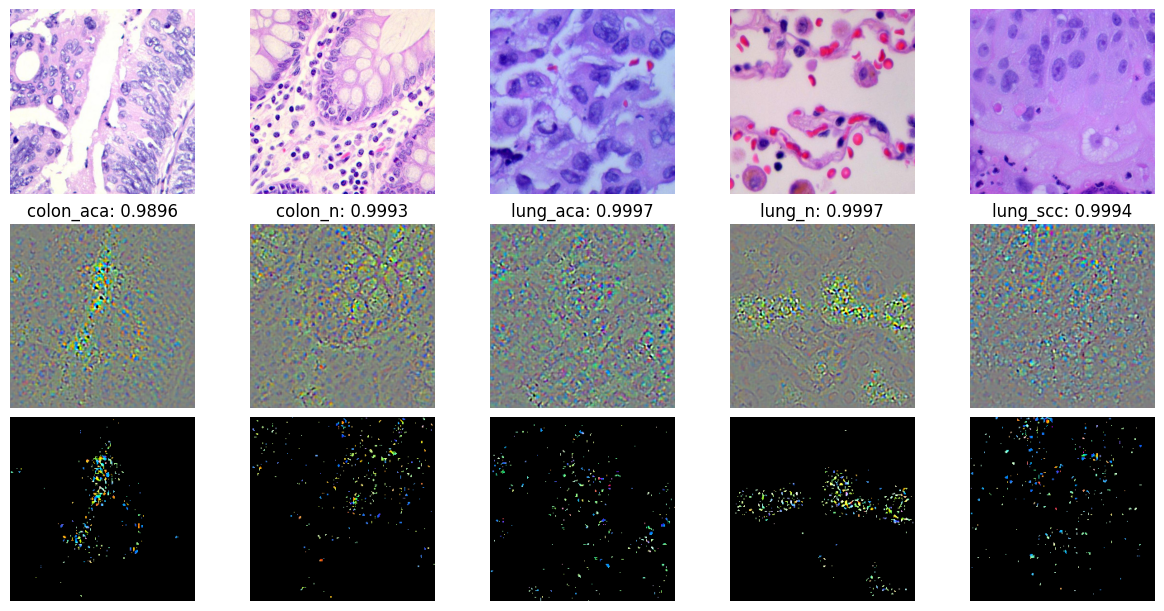

In [12]:
gbp = GuidedBP(resnet18)
result_imgs = []

for class_name, v in class_imgs.items():
    data = v[3].requires_grad_()
    result = gbp.visualize(data, None)
    result_imgs.append(result)

# plot in one figure result_imgs 5x2 and put class label on top of each column
fig, axs = plt.subplots(3, len(result_imgs), figsize=(12, 6), constrained_layout=True)
for i, (img, title) in enumerate(zip(result_imgs, class_imgs.keys())):
    axs[0][i].imshow(random_class_imgs[i][0])
    axs[0][i].axis('off')
    axs[1][i].imshow(clip_and_mask(img, mask_threshold=None))
    axs[1][i].set_title(f"{title}: {class_imgs[title][4][title]:.4f}")
    axs[1][i].axis('off')
    axs[2][i].imshow(clip_and_mask(img, mask_threshold=0.8))
    axs[2][i].axis('off')